In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [2]:
# Load cached data
!wget -nv -O ../data/imagenet/human_readable_labels.json -L https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json
data = np.load('../data/imagenet/imagenet-resnet152.npz')
example_paths = os.listdir('../data/imagenet/examples')
smx = data['smx']
labels = data['labels'].astype(int)

2022-08-18 18:18:40 URL:https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json [14193/14193] -> "../data/imagenet/human_readable_labels.json" [1]


In [3]:
# Problem setup
n=1000 # number of calibration points
alpha = 0.1 # 1-alpha is the desired coverage

In [4]:
# Split the softmax scores into calibration and validation sets (save the shuffling)
idx = np.array([1] * n + [0] * (smx.shape[0]-n)) > 0
np.random.shuffle(idx)
cal_smx, val_smx = smx[idx,:], smx[~idx,:]
cal_labels, val_labels = labels[idx], labels[~idx]

In [5]:
# Get scores. calib_X.shape[0] == calib_Y.shape[0] == n
cal_pi = cal_smx.argsort(1)[:,::-1]; cal_srt = np.take_along_axis(cal_smx,cal_pi,axis=1).cumsum(axis=1)
cal_scores = np.take_along_axis(cal_srt,cal_pi.argsort(axis=1),axis=1)[range(cal_labels.shape[0]),cal_labels]
# Get the score quantile
qhat = np.quantile(cal_scores, np.ceil((n+1)*(1-alpha))/n, interpolation='higher')
# Deploy (output=list of length n, each element is tensor of classes)
val_pi = val_smx.argsort(1)[:,::-1]; val_srt = np.take_along_axis(val_smx,val_pi,axis=1).cumsum(axis=1)
prediction_sets = np.take_along_axis(val_srt <= qhat,val_pi.argsort(axis=1),axis=1)

In [6]:
# Calculate empirical coverage
empirical_coverage = prediction_sets[np.arange(prediction_sets.shape[0]),val_labels].mean()
print(f"The empirical coverage is: {empirical_coverage}")

The empirical coverage is: 0.9123673469387755


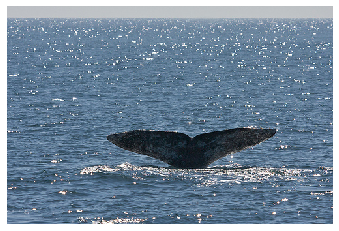

The prediction set is: ['grey whale']


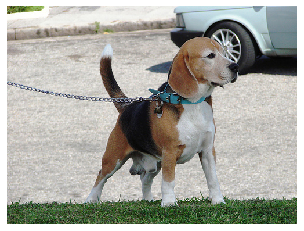

The prediction set is: ['Basset Hound', 'Beagle', 'Bloodhound', 'Bluetick Coonhound', 'Black and Tan Coonhound', 'Treeing Walker Coonhound', 'English foxhound', 'Redbone Coonhound', 'Saluki', 'Greater Swiss Mountain Dog', 'Appenzeller Sennenhund', 'Entlebucher Sennenhund', 'Boxer', 'St. Bernard', 'Basenji', 'Pembroke Welsh Corgi', 'Cardigan Welsh Corgi', 'soccer ball']


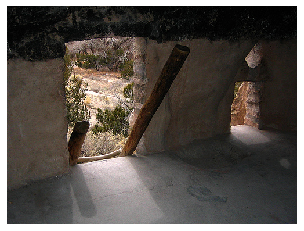

The prediction set is: ['Komodo dragon', 'triceratops', 'wallaby', 'cougar', 'sloth bear', 'porcupine', 'patas monkey', 'Asian elephant', 'waste container', 'baluster', 'barber chair', 'wheelbarrow', 'bathtub', 'breakwater', 'broom', 'bucket', 'cauldron', 'cannon', 'chainsaw', 'cleaver', 'cliff dwelling', 'cradle', 'crutch', 'cuirass', 'dam', 'electric fan', 'flute', 'guillotine', 'hammer', 'harp', 'hatchet', 'hook', 'clothes iron', 'ladle', 'sawmill', 'megalith', 'milk can', 'mortar', 'nail', 'paintbrush', 'patio', 'plow', 'plunger', 'prison', 'radiator', 'rifle', 'rocking chair', 'scabbard', 'weighing scale', 'shopping cart', 'shovel', 'stove', 'sundial', 'mop', 'torch', 'totem pole', 'tub', 'vault', 'sink', 'water jug', 'wooden spoon', 'shipwreck', 'cliff']


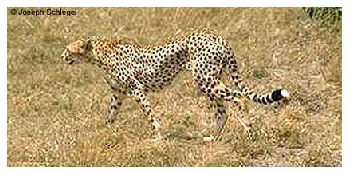

The prediction set is: ['hyena', 'leopard', 'cheetah']


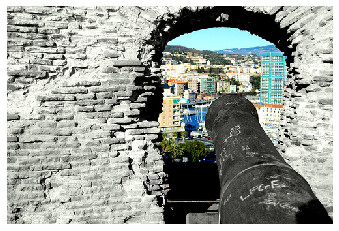

The prediction set is: ['bell-cot', 'cannon']


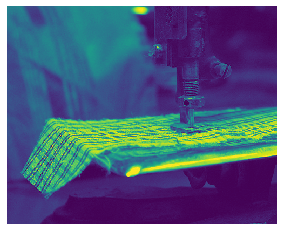

The prediction set is: ['clothes iron', 'nail', 'power drill', 'screw', 'sewing machine']


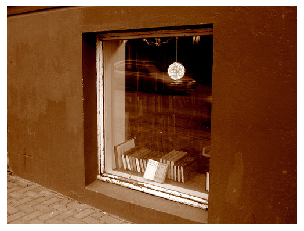

The prediction set is: ['cock', 'conch', 'Australian Silky Terrier', 'Chow Chow', 'red wolf', 'dingo', 'dhole', 'grey fox', 'cockroach', 'orangutan', 'abacus', 'accordion', 'acoustic guitar', 'altar', 'analog clock', 'waste container', 'bakery', 'baluster', 'barber chair', 'barbershop', 'barn', 'barometer', 'barrel', 'wheelbarrow', 'bathtub', 'bell-cot', 'ring binder', 'birdhouse', 'boathouse', 'bookcase', 'bookstore', 'brass', 'broom', 'bucket', 'carton', 'automated teller machine', 'cassette', 'cassette player', 'chain-link fence', 'chest', 'chiffonier', 'chime', 'china cabinet', 'Christmas stocking', 'church', 'movie theater', 'cliff dwelling', 'coil', 'combination lock', 'confectionery store', 'cradle', 'crate', 'crutch', 'desk', 'rotary dial telephone', 'digital clock', 'digital watch', 'dining table', 'dishwasher', 'dome', 'doormat', 'dumbbell', 'electric fan', 'entertainment center', 'envelope', 'filing cabinet', 'fire screen sheet', 'folding chair', 'forklift', 'four-poster bed

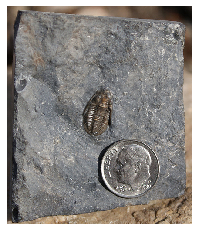

The prediction set is: ['trilobite', 'chiton', 'isopod', 'cockroach', 'armadillo']


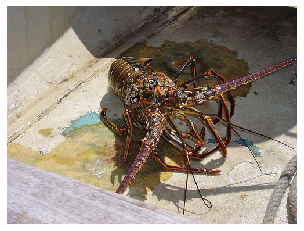

The prediction set is: ['American lobster', 'spiny lobster', 'crayfish']


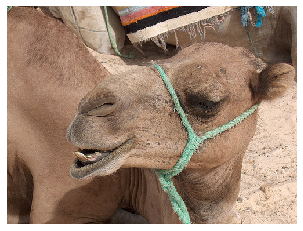

The prediction set is: ['dromedary', 'llama']


In [8]:
# Show some examples
with open('../data/imagenet/human_readable_labels.json') as f:
    label_strings = np.array(json.load(f))

example_paths =os.listdir('../data/imagenet/examples')
for i in range(10):
    rand_path = np.random.choice(example_paths)
    img = imread('../data/imagenet/examples/' + rand_path )
    img_index = int(rand_path.split('.')[0])
    prediction_set = smx[img_index] > 1-qhat
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print(f"The prediction set is: {list(label_strings[prediction_set])}")